In [1]:
# globals for google colab ot not and others
run_on_colab = True
convert_notebook_to_py = False
copy_back_to_drive = False

In [2]:
if run_on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
if run_on_colab:
  !rm -rf /content/code/output/
  !mkdir -p /content/code/output/self_frames/
  %cd /content/code/

  #!pwd

  path_to_hw3 = "/content/drive/MyDrive/studies/master/courses/spring_2020_2021/046746_computer_vision/hw_collab/hw3"
  hw3_code = path_to_hw3 + "/code"

  #ls_command = f"ls {hw3_code}"
  #!$ls_command

  cp_command = f"cp -r {hw3_code}/* ./"
  !$cp_command

  if convert_notebook_to_py:
    !jupyter nbconvert --to python Q2.ipynb --output Q2.py
  
  if copy_back_to_drive:
    cp_command = f"cp ./Q2.py {hw3_code}/"
    !$cp_command
  
  #!ls ./data


/content/code


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from shared_Q1_Q2 import *
from frame_video_convert import *

converting video to frames...
total frames:  608


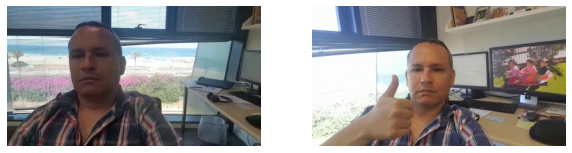

In [17]:


# %% Q 2.1

# %% Convert .mp4 video to .jpg frames 

self_input_file_path = "./my_data/self.mp4"
self_output_dir_path = "./output/self_frames"

video_to_image_seq(self_input_file_path, self_output_dir_path)

# %% Reading 2 frames
frame1_file_path = self_output_dir_path + "/" + "0350.jpg"
frame2_file_path = self_output_dir_path + "/" + "0550.jpg"
me1 = cv2.cvtColor(cv2.imread(frame1_file_path), cv2.COLOR_BGR2RGB)
me2 = cv2.cvtColor(cv2.imread(frame2_file_path), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,15))
my_images = [me1, me2]
for i,file in enumerate(my_images):
  ax = fig.add_subplot(1, len(my_images),i+1)
  ax.imshow(my_images[i])
  ax.set_axis_off()
